In [1]:
import pandas as pd
import glob
from __future__ import division
from __future__ import print_function

In [2]:
# Functions for excluding participants/trials
# Collapse Sklar non-violation conditions into one
# Convert to numeric for NaN cells
def process(list_of_participants):
	cleaned = []
	for frame in list_of_participants:
		frame = frame.replace('Sklar_control_A', 'Sklar_non-violation')
		frame = frame.replace('Sklar_control_B', 'Sklar_non-violation')
		frame = frame.replace('Sklar_filler', 'Sklar_non-violation')#Merges like conditions
		frame = frame.convert_objects(convert_numeric=True)
		cleaned.append(frame)
	print('Done!')
	return cleaned

# Remove any participant with >10% error
def remove_10_percent(list_of_participants):
	reject_participants = []
	accept_participants = []

	# Remove participants who did not respond correctly on more than 10% of the trials 
	for frame in list_of_participants:
		# frame = frame.replace('Sklar_control_A', 'Sklar_non-violation')
		# frame = frame.replace('Sklar_control_B', 'Sklar_non-violation')
		# frame = frame.replace('Sklar_filler', 'Sklar_non-violation')#Merges like conditions
		frame = frame.convert_objects(convert_numeric=True)
		correct = len(frame[frame['match?'] == 1])
		wrong = len(frame[frame['match?'] == 0])
		total = len(frame)
		cutoff = round(total * 0.1)
		if wrong >= cutoff:
			print('\tFAIL on ' + str(frame['SubjNo'].unique()[0]) + '. Cutoff was ' + str(cutoff) + ' but got ' + str(wrong) + ' wrong.')
			reject_participants.append(frame)
		else:
			print('Pass on ' + str(frame['SubjNo'].unique()[0]) + '. Cutoff was ' + str(cutoff) + ' but only got ' + str(wrong) + ' wrong.')
			accept_participants.append(frame)

	# Remove participants with mean RTs that were 3 SDs slower than the group’s mean

	combined = pd.concat(accept_participants)

	group_mean = combined['rt'].mean()
	group_std = combined['rt'].std()

	print(round((len(list_of_participants) - len(accept_participants)) * 100 / len(list_of_participants),2), "% excluded participants:", len(reject_participants), 'out of', len(list_of_participants))

	return accept_participants

# Remove any participant with a mean RT > 3SD of group mean
def remove_3sd_of_group(list_of_participants):
	reject_participants_2 = []
	accept_participants_2 = []

	combined = pd.concat(list_of_participants)

	group_mean = combined['rt'].mean()
	group_std = combined['rt'].std()

	for participant in list_of_participants:
		if participant['rt'].mean() > (group_std * 3.0):
			print('Fail')
			reject_participants_2.append(participant)
		else:
			print('Pass!')
			accept_participants_2.append(participant)

	print('Removed', len(reject_participants_2), 'participants.')

	return accept_participants_2

# For each participant, remove their trials that they got wrong.
def remove_wrong_trials(list_of_participants):
	correct_only = []

	for participant in list_of_participants:
		temp = participant[participant['match?'] == 1]
		correct_only.append(temp)
		right = participant[participant['match?'] == 1]['rt'].count()
		wrong = participant[participant['match?'] == 0]['rt'].count()
		print('Removed', round((wrong/(right+wrong))*100,2), "%")

	return correct_only

# Remove trials that had responses that were more than 3 SDs from each participant’s mean
def remove_3sd_own_trials(list_of_participants):
	within_3sd_own_mean = []

	for participant in list_of_participants:
		p_mean = participant['rt'].mean()
		p_std = participant['rt'].std()
		high = p_mean + (p_std * 3.0) 
		low = p_mean - (p_std * 3.0)

		temp = participant[participant['rt'] <= high]
		temp2 = temp[temp['rt'] >= low]

		start_size = len(participant)
		end_size = len(temp2)
		change = start_size - end_size

		print(start_size, end_size, '% removed:', round((change/start_size) * 100.0,2))

		within_3sd_own_mean.append(temp2)

	return within_3sd_own_mean

# Remove trials that were more than 3 SDs from the general mean for each condition (incoherent or control)
def check_3sd_condition(list_of_participants):
	combined = pd.concat(list_of_participants)
	
	group_stats = {}
	
	for condition in [u'Non-sensible', u'Sensible', u'Sklar_non-violation', u'Sklar_violation']:
		group_stats[condition] = {
			'mean':combined.groupby([u'prime_semantics'])[u'rt'].describe()[condition]['mean'],
			'std':combined.groupby([u'prime_semantics'])[u'rt'].describe()[condition]['std']}


	for participant in list_of_participants:
		for condition in group_stats:
			subject_condition_mean = participant.groupby([u'prime_semantics'])[u'rt'].describe()[condition]['mean']
			group_condition_3sd = group_stats[condition]['std'] * 3.0
			group_condition_mean = group_stats[condition]['mean']
			low = group_condition_mean - group_condition_3sd
			high = group_condition_mean + group_condition_3sd
			print(low, high, subject_condition_mean)
			if subject_condition_mean >= high:
				print('fail')
			else:
				print('\t pass') #Didn't remove any subjects here.
			if subject_condition_mean <= low:
				print('fail')
			else:
				print('\t pass') #Didn't remove any subjects here.

In [11]:
# Load CSV files

files = glob.glob("*.csv")

all_frames = [pd.read_csv(file, header=0, index_col=None) for file in files]

In [18]:
p = process(all_frames)

Done!


In [19]:
p = remove_10_percent(p)

Pass on 10. Cutoff was 44.0 but only got 28 wrong.
Pass on 11. Cutoff was 44.0 but only got 14 wrong.
	FAIL on 12. Cutoff was 44.0 but got 170 wrong.
Pass on 13. Cutoff was 44.0 but only got 3 wrong.
	FAIL on 14. Cutoff was 44.0 but got 129 wrong.
Pass on 15. Cutoff was 44.0 but only got 2 wrong.
Pass on 16. Cutoff was 44.0 but only got 33 wrong.
	FAIL on 17. Cutoff was 44.0 but got 213 wrong.
Pass on 1. Cutoff was 44.0 but only got 5 wrong.
Pass on 2. Cutoff was 44.0 but only got 40 wrong.
Pass on 3. Cutoff was 44.0 but only got 13 wrong.
Pass on 4. Cutoff was 44.0 but only got 6 wrong.
Pass on 5. Cutoff was 44.0 but only got 1 wrong.
Pass on 6. Cutoff was 44.0 but only got 23 wrong.
Pass on 7. Cutoff was 44.0 but only got 10 wrong.
	FAIL on 8. Cutoff was 44.0 but got 69 wrong.
Pass on 9. Cutoff was 44.0 but only got 9 wrong.
23.53 % excluded participants: 4 out of 17


In [20]:
p = remove_wrong_trials(p)

Removed 2.16 %
Removed 3.21 %
Removed 0.69 %
Removed 0.46 %
Removed 0.49 %
Removed 1.15 %
Removed 1.25 %
Removed 2.98 %
Removed 0.92 %
Removed 0.0 %
Removed 3.28 %
Removed 1.84 %
Removed 2.06 %


In [21]:
p = remove_3sd_of_group(p)

Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Pass!
Removed 0 participants.


In [22]:
p = remove_3sd_own_trials(p)

408 403 % removed: 1.23
422 412 % removed: 2.37
433 429 % removed: 0.92
434 425 % removed: 2.07
403 403 % removed: 0.0
431 424 % removed: 1.62
396 389 % removed: 1.77
423 418 % removed: 1.18
430 422 % removed: 1.86
435 426 % removed: 2.07
413 401 % removed: 2.91
426 413 % removed: 3.05
427 419 % removed: 1.87


In [23]:
final = pd.concat(p)

In [24]:
#Aggregated by subject and then condition
final.groupby([u'prime_semantics'])[u'rt'].describe()

prime_semantics           
Non-sensible         count    1865.000000
                     mean        1.525369
                     std         1.050373
                     min         0.458297
                     25%         0.960361
                     50%         1.199027
                     75%         1.599044
                     max         7.904203
Sensible             count    1851.000000
                     mean        1.515076
                     std         1.007573
                     min         0.477951
                     25%         0.968694
                     50%         1.206778
                     75%         1.575541
                     max         7.596931
Sklar_non-violation  count    1248.000000
                     mean        1.491884
                     std         0.955930
                     min         0.476173
                     25%         0.964012
                     50%         1.222665
                     75%         1.583072
       

In [25]:
import scipy.stats

In [26]:
data = {}

for condition in [u'Non-sensible', u'Sensible', u'Sklar_non-violation', u'Sklar_violation']:
	data[condition] = final[final['prime_semantics'] == condition]['rt']

In [27]:
#t-test comparing two conditions, aggregated across all eligible trials
scipy.stats.ttest_ind(data['Sensible'], data['Non-sensible'])

(array(-0.30479565717623347), 0.76053886739177201)

In [28]:
#t-test comparing two conditions, aggregated across all eligible trials
scipy.stats.ttest_ind(data['Sklar_non-violation'], data['Sklar_violation'])

(array(-0.3111706444404149), 0.75570982802736431)

In [36]:
#Just to check
print(scipy.stats.ttest_ind(data['Sensible'], data['Sklar_violation']))
print(scipy.stats.ttest_ind(data['Non-sensible'], data['Sklar_violation']))
print(scipy.stats.ttest_ind(data['Sensible'], data['Sklar_non-violation']))
print(scipy.stats.ttest_ind(data['Non-sensible'], data['Sklar_non-violation']))

(array(0.10918898305242863), 0.91306225345231429)
(array(0.2871502871700742), 0.77402330841990308)
(array(0.6414703702596883), 0.52126459500902667)
(array(0.9033402075998909), 0.36641530281970336)


In [44]:
import seaborn as sns
%matplotlib inline

In [45]:
grouped_data = final.groupby([u'prime_semantics'])[u'rt']

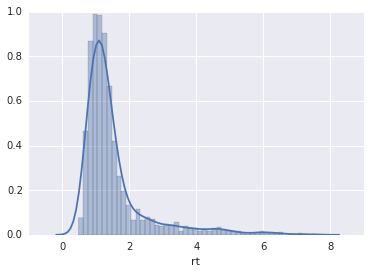

In [56]:
sns.distplot(grouped_data.get_group('Sensible'))

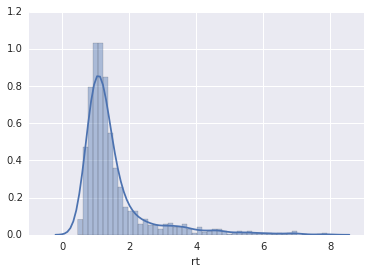

In [52]:
sns.distplot(grouped_data.get_group('Non-sensible'))

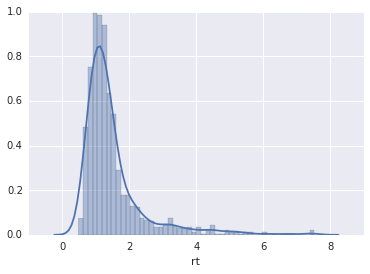

In [53]:
sns.distplot(grouped_data.get_group('Sklar_non-violation'))

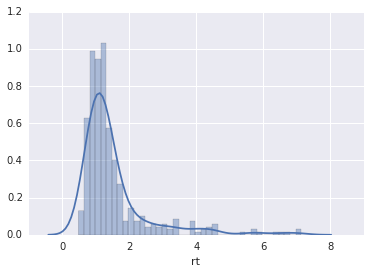

In [54]:
sns.distplot(grouped_data.get_group('Sklar_violation'))

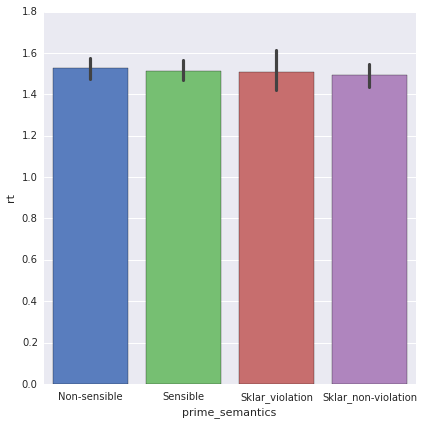

In [58]:
graph = sns.factorplot(
	x='prime_semantics', 
	y="rt", 
	data=final,
	size=6, 
	kind="bar", 
	palette="muted",
	order=[u'Non-sensible', u'Sensible', u'Sklar_violation', u'Sklar_non-violation'])